In [1]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from nbodykit import style

from collections import OrderedDict, namedtuple
import cPickle
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, MaxNLocator, AutoMinorLocator
import numpy as np
import os
import random
from scipy import interpolate as interp


#import constants
import logbook_main_calc_RSD_Perr_pickles
from lsstools.cosmo_model import CosmoModel
from lsstools.gen_cosmo_fcns import calc_f_log_growth_rate, generate_calc_Da
from lsstools.model_spec import get_trf_spec_from_list
from perr.path_utils import get_in_path
from lsstools.results_db import retrieve_pickles
from lsstools.results_db.io import Pickler

plt.style.use(style.notebook)
colors = [d['color'] for d in style.notebook['axes.prop_cycle']]
linestyles = ['-', (0, [12, 6]), (10, [14, 4, 2, 4]), (0, [3, 3]), (0, [1, 1]), (0, [8, 4])]

In [2]:
# Options to load pickles

#sim_seeds = [400,401]
sim_seeds = range(400,406)
#sim_seeds = range(400,404)

# path of pickles
pickle_path = os.path.expandvars('$SCRATCH/perr/pickle/')

## Which pickle to load. Edit logbook....py to select a pickle.
loginfo = logbook_main_calc_RSD_Perr_pickles.get_pickle_fname()
fname = loginfo['fname']
base_pickle_fname = fname
plot_opts = loginfo['plot_opts']

# Default args for varying base params and stacking.
# Will vary params (halo mass) and stack realizations in plot below.
default_stack_and_vary_kwargs = dict(
    pickle_path=pickle_path,
    base_fname=fname,
    comp_key='opts',
    fname_pattern=r'^main_calc_Perr.*.dill$',
    ignore_pickle_keys=['pickle_fname', 'out_rho_path', 'in_path', 'cats'],
    skip_keys_when_stacking=['opts', 'flat_opts', 'cat_infos'],
    return_base_vp_pickles=True,
    return_base_vp_pickle_opts=True,
    get_in_path=get_in_path)

## params to vary: difft mass bins
varyparams = OrderedDict()
if False:
    # halos
    #halo_masses = [(10.8, 11.8), (11.8, 12.8), (12.8, 13.8), (13.8, 15.1)]
    halo_masses = [(13.8,15.1)]
    halo_mass_strings = ['%.1f_%.1f' % (hm[0], hm[1]) for hm in halo_masses]
else:
    # galaxies
    halo_masses = [(np.nan,np.nan)]
    halo_mass_strings = ['']

for halo_mass_string in halo_mass_strings:
    varyparams[((('sim_opts', 'halo_mass_string',),
                 halo_mass_string),)] = dict()
del halo_mass_string

# get stacked pickles for each entry of varyparams
stacked_vp_pickles, base_vp_pickles, base_vp_pickles_flat_opts = (
    retrieve_pickles.get_stacked_pickles_for_varying_base_opts(
        stack_key=('sim_opts','sim_seed'),
        stack_values=sim_seeds,
        base_param_names_and_values=varyparams.keys(),
        **default_stack_and_vary_kwargs))

print('Retrieved pickles')


#target_and_title = ('delta_h', 'Halos')
#target_and_title = ('delta_g', 'HOD galaxies')
#target_and_title = ('delta_gc', 'HOD centrals')
#target_and_title = ('delta_gp', 'HOD parent halos')
#target_and_title = ('delta_gs', 'HOD satellites')
#target_and_title = ('delta_gPTC', 'PTChall galaxies')
#target_and_title = ('delta_gPTC_GodPsiDot1', 'PTChall God galaxies')
target_and_title = ('delta_gPTC_11.5', 'PTChall galaxies, M>11.5')

target, title = target_and_title

#save_bestfit_field='hat_%s_RSD001_from_1_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001' % target
#save_bestfit_field='hat_%s_RSD001_from_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001' % target
#save_bestfit_field='hat_%s_RSD001_from_1_G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001' % target
save_bestfit_field='hat_%s_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001' % target

PicklesDB: Open /Users/mschmittfull/scratch_data//perr/pickle/main_calc_Perr..dill.db
PicklesDB: Delete empty pickle files...
PicklesDB: Read all pickles to update db...
PicklesDB: Have 450 files
Search for  main_calc_Perr_2020_Sep_03_09:14:30_time1599124470.dill
entries: [{u'f_log_growth': 0.7862982128, u'pickle_file_format': u'dill', u'ext_grids_to_load': {u'deltalin_G2_par_LOS001_SHIFTEDBY_deltalin': {u'scale_factor': 0.625, u'file_format': u'nbkit_BigFileGrid', u'nbkit_normalize': True, u'dir': u'IC_LinearMesh_tidal_G2_par_LOS001_intR0.00_extR0.00_SHIFTEDBY_IC_LinearMeshR0.69_a0.6250_Np1536_Nm1536_Ng1536_CICsum', u'nbkit_setMean': 0.0, u'dataset_name': u'Field'}, u'1_SHIFTEDBY_deltalin_RSD001': {u'scale_factor': 0.625, u'file_format': u'nbkit_BigFileGrid', u'nbkit_normalize': True, u'dir': u'1_intR0.00_extR0.00_SHIFTEDBY_IC_LinearMeshR0.69_a0.6250_Np1536_Nm1536_Ng1536_CICsum_RSD001', u'nbkit_setMean': 0.0, u'dataset_name': u'Field'}, u'deltalin_G2_SHIFTEDBY_deltalin_RSD001': {u'sca

In [3]:
def get_cic_window(boxsize=None, Ngrid=None, kvec=None):

    # CIC window (eq. 21 from jing et al 
    # https://arxiv.org/pdf/astro-ph/0409240.pdf)
    Delta_x = boxsize / float(Ngrid)
    k_nyq = np.pi / Delta_x
    nbar_kvec = np.zeros(kvec.shape[0] + 1)
    nbar_kvec[0] = kmin_plot
    nbar_kvec[1:] = kvec
    cic_window = 1.0 - 2. / 3. * (np.sin(np.pi * nbar_kvec /
                                     (2.0 * k_nyq)))**2
    eval_cic_window_at_kvec = lambda mykvec: 1.0 - 2. / 3. * (np.sin(
        np.pi * mykvec / (2.0 * k_nyq)))**2

    return cic_window, eval_cic_window_at_kvec

def get_tsc_window(boxsize=None, Ngrid=None, kvec=None):

    #raise Exception('Field level code doesn not use tsc when shifting partciles, so dont divide by tsc window')
    
    # tsc window (eq. 21 from jing et al 
    # https://arxiv.org/pdf/astro-ph/0409240.pdf)
    Delta_x = boxsize / float(Ngrid)
    k_nyq = np.pi / Delta_x
    nbar_kvec = np.zeros(kvec.shape[0] + 1)
    nbar_kvec[0] = kmin_plot
    nbar_kvec[1:] = kvec
    tsc_window = (1.0 
                  - (np.sin(np.pi * nbar_kvec / (2.0 * k_nyq)))**2
                  + 2./15. * (np.sin(np.pi * nbar_kvec / (2.0 * k_nyq)))**4 )
    eval_tsc_window_at_kvec = lambda mykvec: (
        1.0 
        - (np.sin(np.pi * mykvec / (2.0 * k_nyq)))**2
        + 2./15.*(np.sin(np.pi * mykvec / (2.0 * k_nyq)))**4 )

    return tsc_window, eval_tsc_window_at_kvec

def get_window_compensation(window='cic', boxsize=None, Ngrid=None, kvec=None):
    if window == 'cic':
        return get_cic_window(boxsize=boxsize, Ngrid=Ngrid, kvec=kvec)
    elif window == 'tsc':
        return get_tsc_window(boxsize=boxsize, Ngrid=Ngrid, kvec=kvec)
    else:
        raise Exception('Invalid window %s' % window)

def get_nbar_of_cat(base_pickle):
    nbar_of_cat = OrderedDict()
    cat_infos = base_pickle['cat_infos']
    for catid, cat_info in cat_infos.items():
        if cat_info.has_key('simple'):
            if cat_info['simple'].has_key('nbar_nonuni_cat'):
                nbar_of_cat[catid] = cat_info['simple']['nbar_nonuni_cat']
            elif cat_info['simple'].has_key('nbar'):
                nbar_of_cat[catid] = cat_info['simple']['nbar']

    return nbar_of_cat

In [5]:
if not os.path.exists('../pdf'):
    os.makedirs('../pdf/')

stacked_vp_pickles keys: [((('sim_opts', 'halo_mass_string'), ''),)]
tmp: ['save_grids4plots', 'f_log_growth', 'out_rho_path', 'Pkmeas_helper_columns_calc_crosses', 'pickle_file_format', 'pickle_path', 'Pkmeas_helper_columns', 'power_opts', 'store_Pkmeas_in_trf_results', 'code_version_for_pickles', 'trf_specs', 'grids4plots_base_path', 'trf_fcn_opts', 'cats', 'grids4plots_R', 'ext_grids_to_load', 'grid_opts', 'sim_opts', 'keep_pickle', 'in_path', 'cache_base_path']
Nsims: 6
Made ../pdf/Tk_RSD_v2.pdf


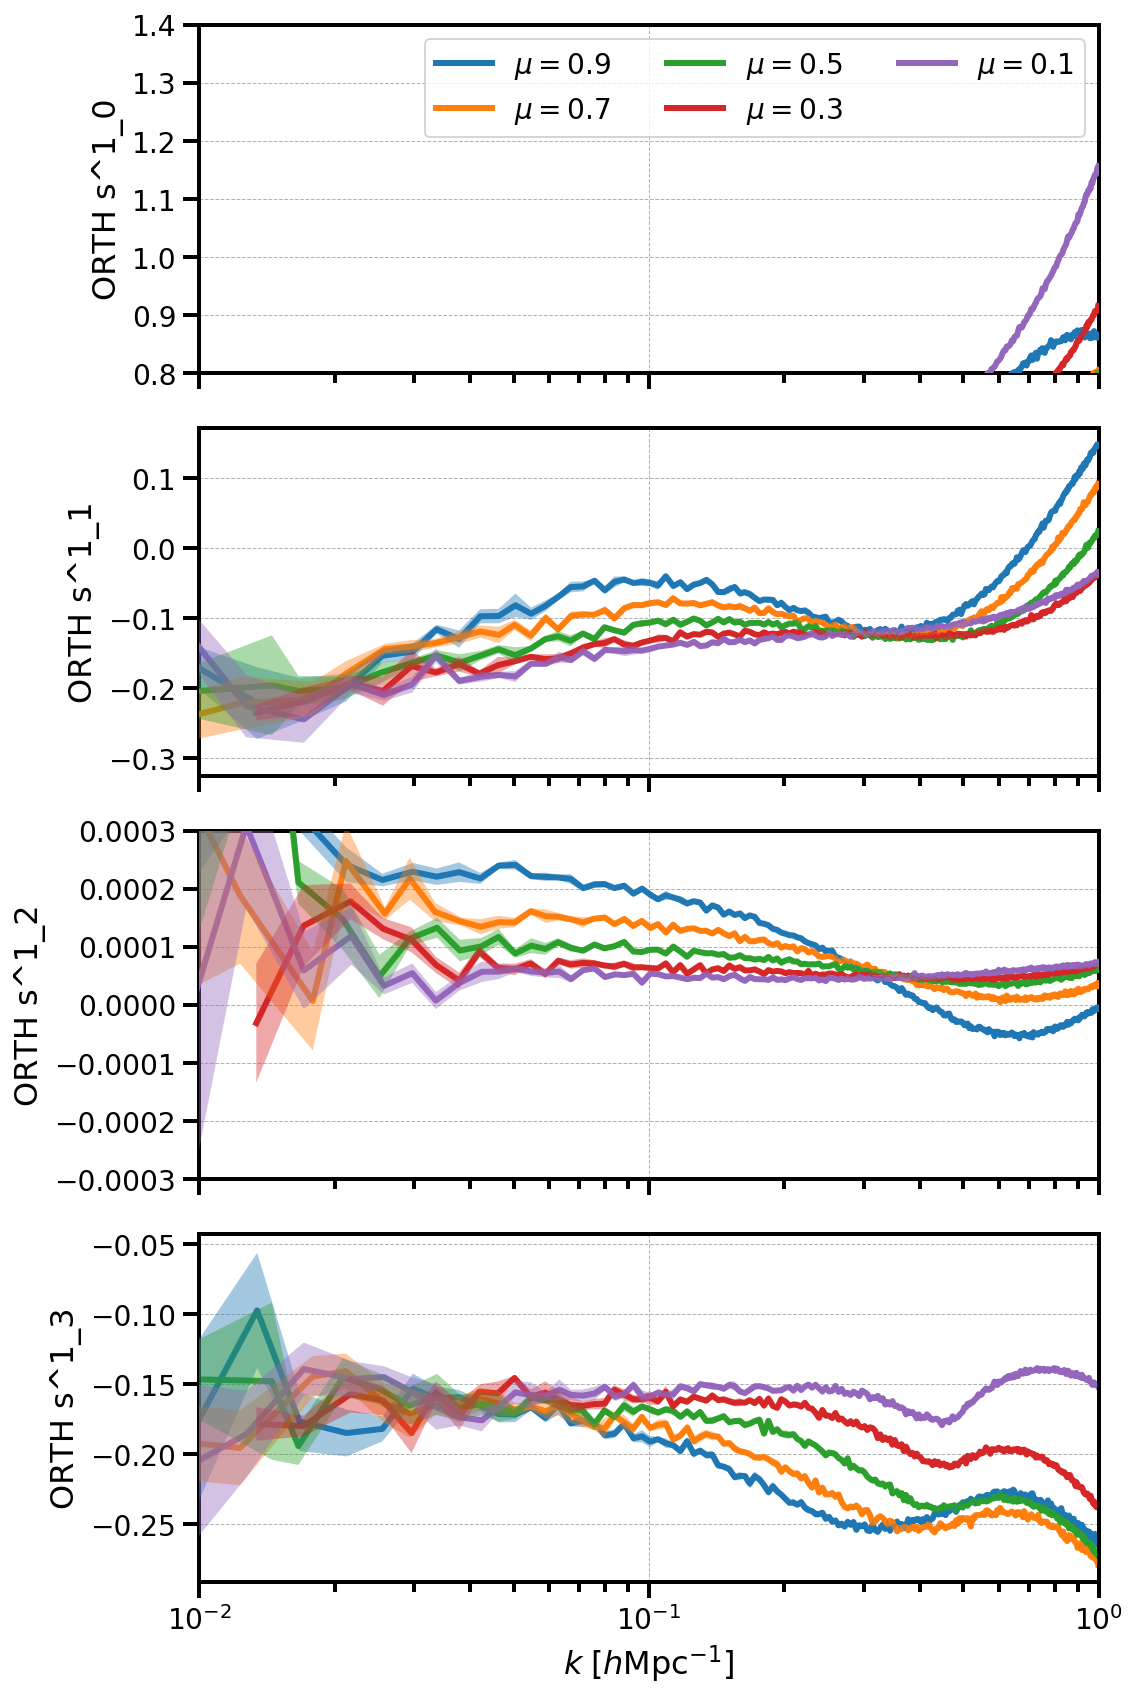

In [6]:
if True:
    # #################################################################################
    # PLOT trf functions in redshift space
    # #################################################################################

    # where to write files for marko
    export_marko = False
    out_dir = '../for_marko/%s/' % base_pickle_fname
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    # select halo mass bin (0 for galaxies)
    iM = 0
    log10M_min, log10M_max = halo_masses[iM]
    halo_mass_string = halo_mass_strings[iM]
   
    fig, axarr = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

    vpkey = ((('sim_opts', 'halo_mass_string',), halo_mass_string),)

    print("stacked_vp_pickles keys:", stacked_vp_pickles.keys())
    stacked_pickles = stacked_vp_pickles[vpkey]
    base_pickle_opts = base_vp_pickles[vpkey]['opts']

    # get some basic info
    boxsize = int(base_pickle_opts['sim_opts'].boxsize)
    redshift = 1.0 / base_pickle_opts['sim_opts'].sim_scale_factor - 1.0
    kmin_plot = 1e-2
    kmax_plot = np.min(np.array([1.0, base_pickle_opts['grid_opts'].kmax]))

    base_pickle = base_vp_pickles[vpkey]
    print("tmp:", base_pickle['opts'].keys())
    trf_specs = base_pickle['opts']['trf_specs']
    trf_specs_save_bestfit_fields = [t.save_bestfit_field for t in trf_specs]
    trf_specs_targets = [t.target_field for t in trf_specs]

    # try to read number density:
    nbar_of_cat = get_nbar_of_cat(base_pickle)
    if nbar_of_cat.has_key(target):
        my_one_over_nbar = 1.0 / nbar_of_cat[target]
        denomi = my_one_over_nbar
    else:
        denomi = 1.0

    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    Nsims = stacked_pickles['Pkmeas'][tmp_key]['k'].shape[0]
    print("Nsims:", Nsims)
    assert Nsims == len(sim_seeds)

    N_ortho_iter = base_pickle_opts['trf_fcn_opts'].N_ortho_iter
    if N_ortho_iter == 0:
        orig_or_orth = 'orig'
    else:
        orig_or_orth = 'orth'

    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    kvec = np.mean(stacked_pickles['Pkmeas'][tmp_key]['k'], axis=0)

    ### GET CIC OR TSC WINDOW
    window_at_kvec, eval_window_at_kvec = get_window_compensation(
        window=base_pickle_opts['power_opts'].to_mesh_kwargs['window'],
        boxsize=base_pickle_opts['sim_opts'].boxsize, Ngrid=base_pickle_opts['grid_opts'].Ngrid,
        kvec=kvec)
    
    
    # get Pks, Nmu, Nk
    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    Pks = stacked_pickles['Pkmeas']
    Pk0 = Pks[Pks.keys()[0]]
    Nmu = Pk0['Nmu'][0][0]
    Nk = Pk0['Nk'][0][0]

    # plot the following trf specs
    tfspec = get_trf_spec_from_list(
        trf_specs=trf_specs, 
        save_bestfit_field=save_bestfit_field
    )

    ## GET TRF FCNS
    # get trf fcns of orthogonal or original fields
    this_trf_results_RSD = stacked_pickles['trf_results'][str(tfspec)]
    target_RSD = tfspec.target_field
    trf_fcns_orth_RSD = this_trf_results_RSD['trf_fcns_orth_fields'].get(target_RSD, None)

    # properties
    N_ortho_iter = base_pickle_opts['trf_fcn_opts'].N_ortho_iter
    sources = base_pickle['trf_results'][str(
       tfspec)]['trf_fcns_orth_fields'][target_RSD].keys()
    Nsources = len(sources)
    fixed_linear_sources = tfspec.fixed_linear_sources
    
    
    # plot
    color_counter = -1
    for imu in range(Nmu)[::-1]:
        color_counter += 1

        # read kvec of current mu bin from realization 0
        kvec_this_mu = Pks[Pks.keys()[0]]['k2d'][0, :, imu]
        mu = Pks[Pks.keys()[0]]['mu2d'][0, -1, imu]

        

        # loop over source terms
        for isource, source in enumerate(sources):

            ax = axarr[isource]
            plt.sca(ax)

            # COMPUTE TRF FCN
            kvec_flat, muvec_flat = trf_fcns_orth_RSD[source][0]
            otf_RSD = trf_fcns_orth_RSD[source][1]
            expected_shape = (Nsims,Nk*Nmu)
            for v in [kvec_flat, muvec_flat, otf_RSD]:
                assert v.shape == expected_shape
            # reshape
            kvec_2d = kvec_flat.reshape(Nsims, Nk, Nmu)
            otf_RSD_2d = otf_RSD.reshape(Nsims, Nk, Nmu)

            # check reshape was correct
            #print('kvec_this_mu:', kvec_this_mu)
            #print('kvec_2d at this mu for 1st realization:', kvec_2d[0,:,imu])
            assert np.allclose(kvec_2d[0,:,imu], kvec_this_mu, equal_nan=True)

            #if N_ortho_iter == 1:
            ymat = otf_RSD_2d[:,:,imu]

            # plot
            label = "$T_{%d}'$" % isource
            mylabel = label
            if False:
                bias_label = get_model_contri_label_of_source(
                    source,
                    N_ortho_iter,
                    this_trf_results['info']
                    ['initial_source_of_osource'],
                    offset=trf_offset_of_isource[isource])
                if show_legend:
                    mylabel = bias_label
                else:
                    mylabel = '_nolabel_'
            ww = np.where((kvec_this_mu>0.0045) & (kvec_this_mu<=1.0))[0]
            if True:
                # plot errors using fill_between
                yerr = np.std(ymat[:,:], axis=0) / np.sqrt(
                    float(Nsims - 1))
                mypatch = ax.fill_between(kvec_this_mu[ww],
                    (np.mean(ymat[:,ww], axis=0) - yerr[ww]) / eval_window_at_kvec(kvec_this_mu[ww]),
                    (np.mean(ymat[:,ww], axis=0) + yerr[ww]) / eval_window_at_kvec(kvec_this_mu[ww]),
                    facecolor=colors[color_counter],
                    zorder=len(sources) - isource + 1 + 3,
                    lw=0, alpha=0.4)

            if True:
                # plot lines without error bars
                ax.semilogx(kvec_this_mu[ww], 
                            np.mean(ymat[:,ww], axis=0) / eval_window_at_kvec(kvec_this_mu[ww]),
                    zorder=len(sources) - isource + 1,
                    lw=3, alpha=1, color=colors[color_counter], ls='-', 
                    label=r'$\mu=%.2g$' % mu)
                
            # cosmetics
            ax.set_ylabel(source)
            ax.set_xlim((0.01,1))
            if ax == axarr[0]:
                ax.legend(loc='best', fontsize=14, ncol=3)
                #ax.set_ylim((0.8,3))
                ax.set_ylim((0.8,1.4))
                

            if ax == axarr[-2]:
                ax.set_ylim((-0.0003,0.0003))
            if ax == axarr[-1]:
                ax.set_xlabel('$k\;[h\\mathrm{Mpc}^{-1}]$')
              
            if export_marko:
                if not os.path.exists(out_dir):
                    os.makedirs(out_dir)
                # export to file for marko
                out_mat = np.zeros((kvec_this_mu.shape[0], 3)) + np.nan
                out_mat[:,0] = kvec_this_mu
                out_mat[:,1] = np.mean(ymat, axis=0)/eval_window_at_kvec(kvec_this_mu)
                out_mat[:,2] = yerr/eval_window_at_kvec(kvec_this_mu)
                out_fname = os.path.join(out_dir, 'Tk_M%d_source%d_mu%d.txt' % (
                    iM, isource, imu))
                header = 'Mmin=%g, Mmax=%g, mu=%g\nBase pickle file: %s\nColumns: k, <T(k,mu)>, error of T(k,mu) estimated from scatter between sims' % (
                    log10M_min, log10M_max, mu, base_pickle_fname)
                np.savetxt(out_fname, out_mat, header=header)
                print('Wrote %s' % out_fname)

    plt.tight_layout()
    fname = '../pdf/Tk_RSD_v2.pdf'
    plt.savefig(fname)
    print('Made %s' % fname)

## Fit transfer function b1(k,mu) ##

In [7]:
FIT_TRF_FCNS = True

In [8]:
Pks[Pks.keys()[0]]['Nmodes'].shape


(6, 3840)

In [9]:
import statsmodels.api as sm

In [10]:
if True:

    # specify regression features: k^n mu^m
    def get_trf_features_from_k_mu(ki, mui, target_field, isource):

        if isource == 0:
            # fit b1(k,mu) with k and mu polys
            if target_field == 'delta_gPTC_RSD001':
                #X = np.column_stack(( np.ones(ki.shape[0]), ki**1.2  ) )
                #X = np.column_stack(( np.ones(ki.shape[0]), ki, ki**2  ) )
                X = np.column_stack(( np.ones(ki.shape[0]), ki, ki**2, ki**1*mui**4  ) )

            elif target_field == 'delta_gPTC_11.5_RSD001':
                #X = np.column_stack(( np.ones(ki.shape[0]), ki, ki**2, ki**4*mui  ) )
                X = np.column_stack(( np.ones(ki.shape[0]), ki, ki**2, ki**1*mui**4  ) )

            else: 
                raise Exception('INvalid target_field %s' % target_field)
        else:
            # fit higher order biases with constant
            X = np.column_stack(( np.ones(ki.shape[0]),  ) )

        return X

    # fit all bias trf fcns
    fitresults_of_source = OrderedDict()
    b_kmin_fit_of_isource = np.zeros(len(sources))+np.nan
    b_kmax_fit_of_isource = np.zeros(len(sources))+np.nan
    for isource, source in enumerate(sources):
        print('\n\n\nFitting %s' % source)

        # get b_i(k,mu)
        # 1d vectors having (k_i, mu_i) of i-th k,mu bin
        kvec, muvec = trf_fcns_orth_RSD[source][0]
        kvec = np.mean(kvec, axis=0)
        muvec = np.mean(muvec, axis=0)
        # divide out window from trf fcn
        bvec = np.mean(trf_fcns_orth_RSD[source][1] / eval_window_at_kvec(kvec), axis=0)
        Nmodesvec = np.mean(Pks[Pks.keys()[0]]['Nmodes'][:, :], axis=0)
        expected_shape = (Nk*Nmu,)
        for v in [kvec, muvec, bvec]:
            assert v.shape == expected_shape

        if isource == 0:
            b_kmin_fit, b_kmax_fit = 0.02, 0.2
        else:
            b_kmin_fit, b_kmax_fit = 0.02, 0.1

        b_kmin_fit_of_isource[isource] = b_kmin_fit
        b_kmax_fit_of_isource[isource] = b_kmax_fit


        ww = np.where( (kvec>b_kmin_fit) & (kvec<=b_kmax_fit) )[0]
        ki = kvec[ww]
        mui = muvec[ww]
        yi = bvec[ww]
        Nmodesi = Nmodesvec[ww]

        # compute design matrix
        X = get_trf_features_from_k_mu(ki, mui, tfspec.target_field, isource)

        #model = sm.OLS(yi, X)
        model = sm.WLS(yi, X, weights=1./Nmodesi)  # WLS takes sqrt of weights

        fitresults_of_source[source] = model.fit()
        print('FIT RESULTS FOR SOURCE %s' % source)
        print(fitresults_of_source[source].summary())
        del model




Fitting ORTH s^1_0
FIT RESULTS FOR SOURCE ORTH s^1_0
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.908
Model:                            WLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     694.7
Date:                Tue, 24 Nov 2020   Prob (F-statistic):          4.91e-109
Time:                        21:48:57   Log-Likelihood:                 651.15
No. Observations:                 215   AIC:                            -1294.
Df Residuals:                     211   BIC:                            -1281.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less_equal
/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model
/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


In [11]:
if FIT_TRF_FCNS:

    # save fitresult
    fitted_stacked_pickles = OrderedDict()
    fitted_stacked_pickles['trf_results'] = OrderedDict()
    mykvec = stacked_pickles['trf_results'][str(tfspec)]['kvec']
    mymuvec = stacked_pickles['trf_results'][str(tfspec)]['muvec']
    fitted_stacked_pickles['trf_results'][str(tfspec)] = {
        'kvec': mykvec,
        'muvec': mymuvec,
        'trf_fcns_%s_fields' % orig_or_orth: {tfspec.target_field: {}}}

    # save fitted b_i(k,mu)
    for isource, source in enumerate(sources):
        this_X = get_trf_features_from_k_mu(
            np.mean(fitted_stacked_pickles['trf_results'][str(tfspec)]['kvec'], axis=0),
            np.mean(fitted_stacked_pickles['trf_results'][str(tfspec)]['muvec'], axis=0),
            tfspec.target_field, isource)
        # use same format as stacked_pickles: [[kvec, muvec], T(k)]
        fitted_stacked_pickles['trf_results'][str(tfspec)]['trf_fcns_%s_fields' % orig_or_orth][tfspec.target_field][source] = [
            [mykvec, mymuvec],
            fitresults_of_source[source].predict(this_X)]

    print(stacked_pickles['trf_results'][str(tfspec)].keys())
    print(stacked_pickles['trf_results'][str(tfspec)]['trf_fcns_orth_fields'][tfspec.target_field].keys())
    print(fitted_stacked_pickles['trf_results'][str(tfspec)]['trf_fcns_orth_fields'][tfspec.target_field].keys())

['info', 'Pkmeas', 'kvec', 'muvec', 'trf_fcns_orth_fields', 'trf_fcns_orig_fields']
['ORTH s^1_0', 'ORTH s^1_1', 'ORTH s^1_2', 'ORTH s^1_3']
['ORTH s^1_0', 'ORTH s^1_1', 'ORTH s^1_2', 'ORTH s^1_3']


### Plot fitted transfer functions ###

Made ../pdf/Tk_RSD_v2_fit.pdf


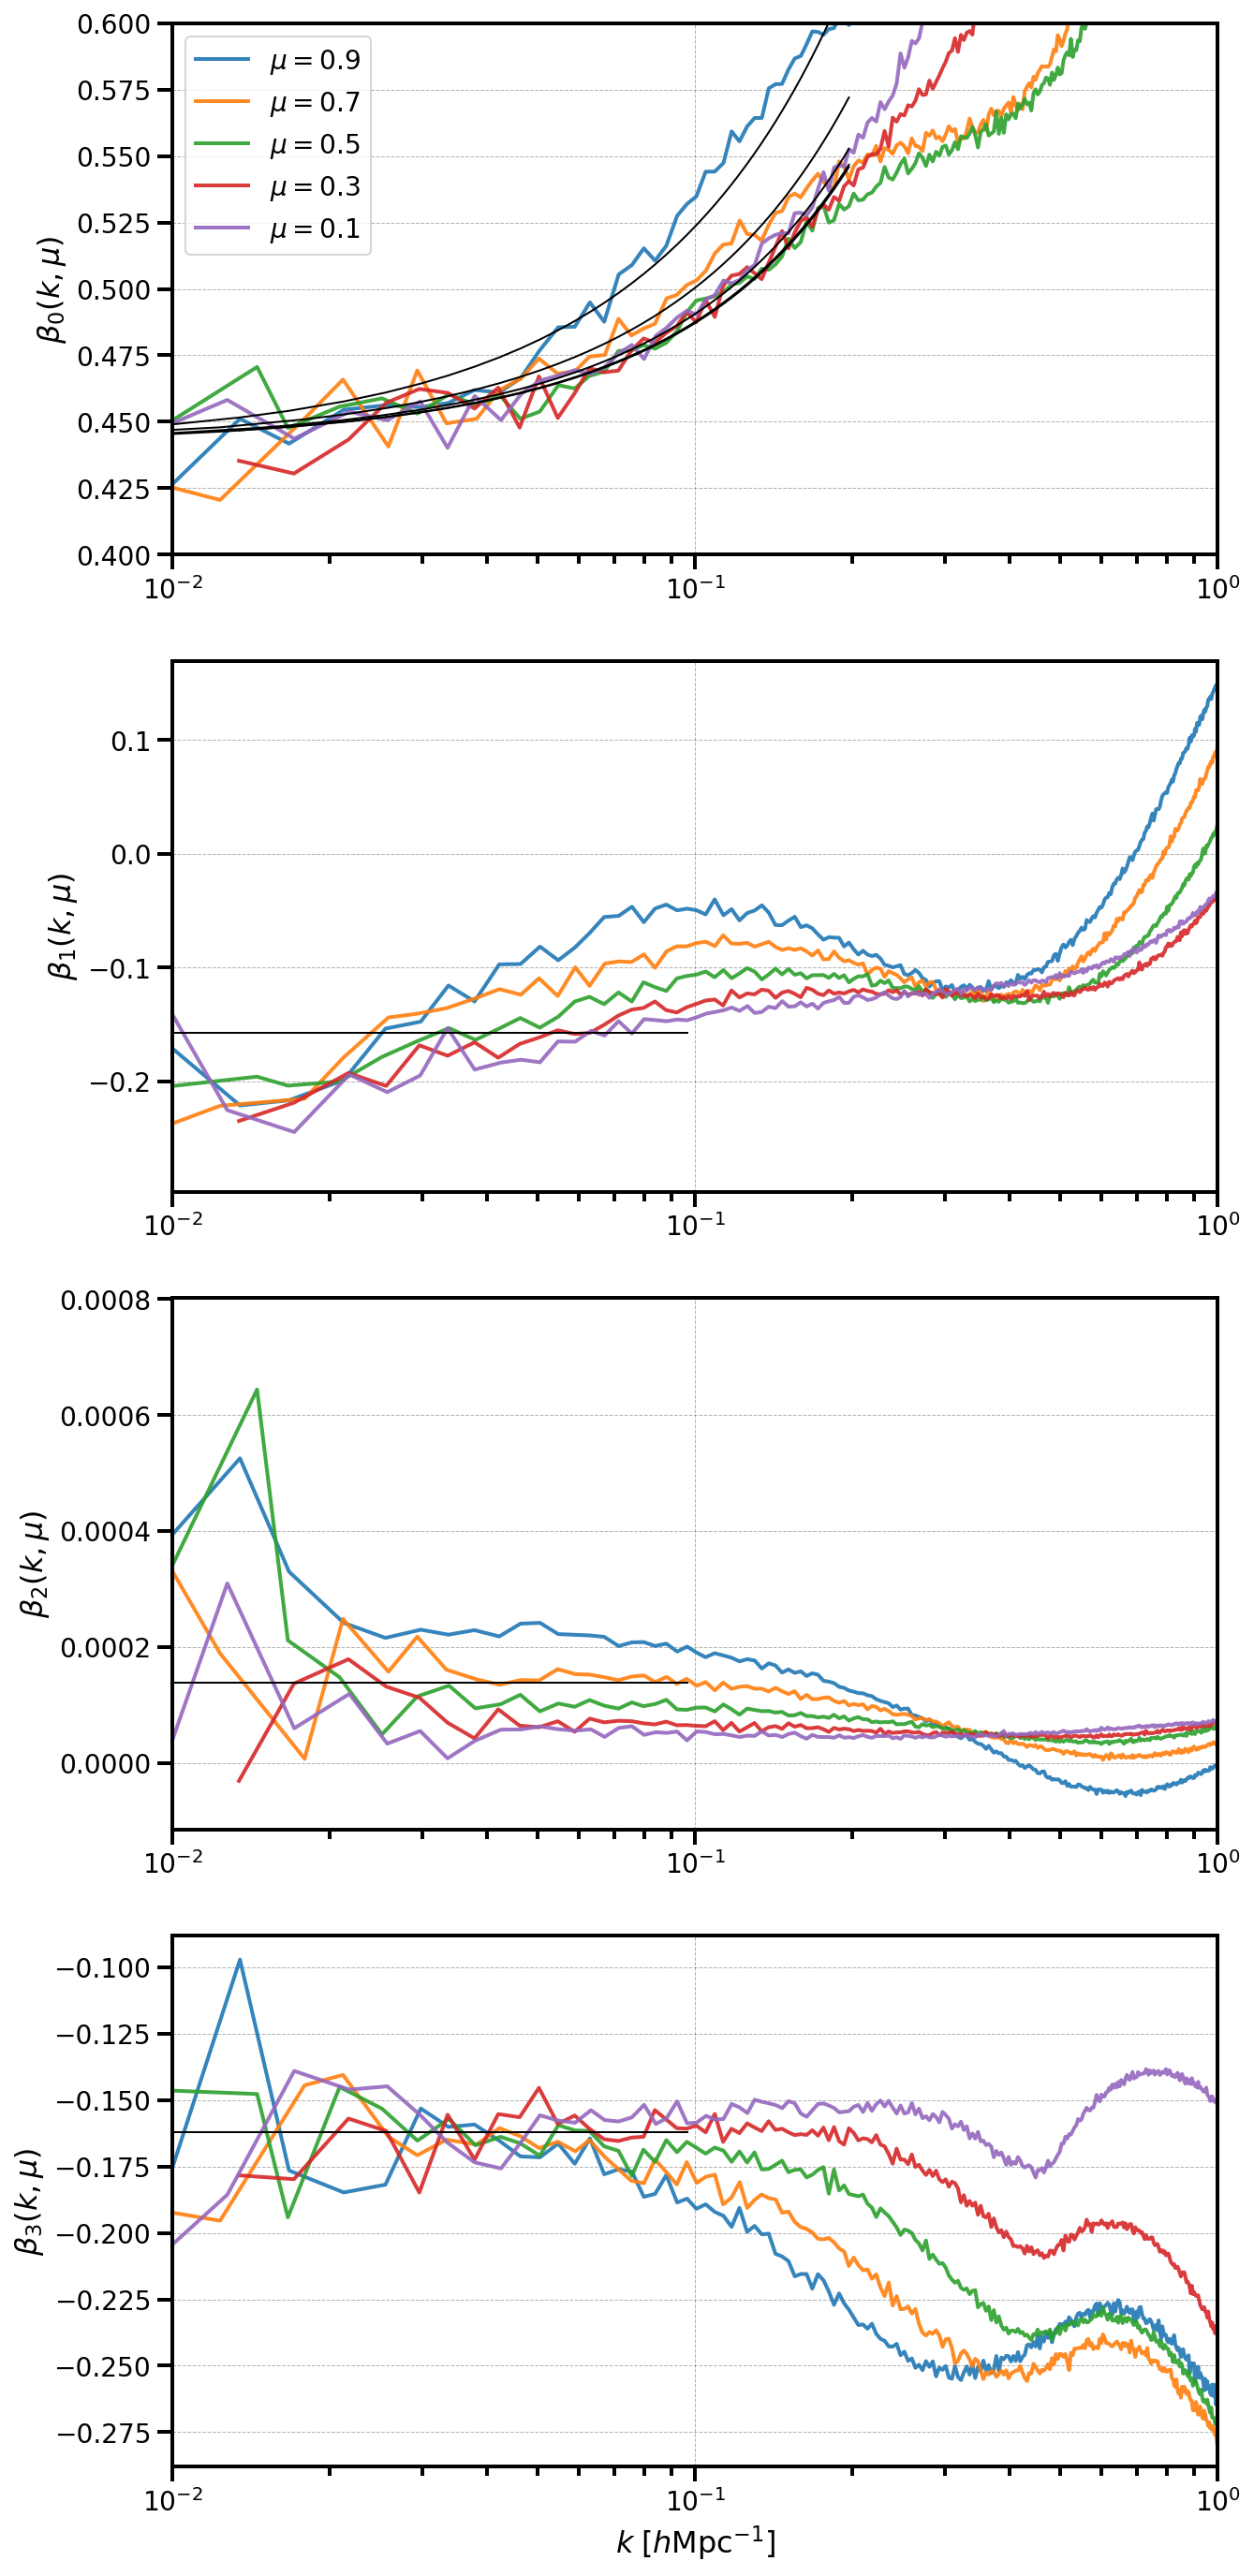

In [12]:
if FIT_TRF_FCNS:

    fig, axarr = plt.subplots(len(sources),1, figsize=(10,6*len(sources)))

    # reshape
    kvec_2d = kvec.reshape(Nk, Nmu)

    for isource, source in enumerate(sources):
        ax = axarr[isource]

        color_counter = -1
        for imu in range(Nmu)[::-1]:
            color_counter += 1

            kvec_this_mu = kvec_2d[:,imu]
            mu = Pks[Pks.keys()[0]]['mu2d'][0, -1, imu]      
            ww = np.where((kvec_this_mu>0.0045) & (kvec_this_mu<=1.0))[0]

            # plot full trf fcn b1(k,mu)
            bvec = np.mean(trf_fcns_orth_RSD[source][1] / eval_window_at_kvec(kvec), axis=0)
            bvec_2d = bvec.reshape(Nk, Nmu)
            ax.semilogx(kvec_this_mu[ww],
                        bvec_2d[ww,imu],
                #zorder=len(sources) - isource + 1,
                lw=2, alpha=0.9, color=colors[color_counter], ls='-', 
                label=r'$\mu=%.2g$' % mu)

            # plot fitted trf fcn. this includes window already so don't divide out
            ww = np.where((kvec_this_mu>0.0045) & (kvec_this_mu<=b_kmax_fit_of_isource[isource]))[0]
            this_ki = kvec_this_mu[ww]
            this_mui = np.ones(this_ki.shape)*mu
            this_X = get_trf_features_from_k_mu(this_ki, this_mui, tfspec.target_field, isource)
            ax.semilogx(kvec_this_mu[ww], fitresults_of_source[source].predict(this_X), '-', 
                         color='k',
                         #color=colors[color_counter],
                         lw=1, alpha=1, zorder=10)

        # cosmetics
        ax.set_xlim((0.01,1))
        ax.set_ylabel(r'$\beta_%d(k,\mu)$' % isource)
        if isource == 0:
            if target == 'delta_gPTC':
                ax.set_ylim((0.9,1.8))
            elif target == 'delta_gPTC_11.5':
                ax.set_ylim((0.4,0.6))

    axarr[-1].set_xlabel('$k\;[h\\mathrm{Mpc}^{-1}]$')
    axarr[0].legend(fontsize=14, loc='best');
    pltname = '../pdf/Tk_RSD_v2_fit.pdf'
    plt.savefig(pltname)
    print('Made %s' % pltname)

### Compute Pmodel and Perr using fitted trf fcns ###

In [13]:
print(tfspec.target_field)
print(sources)
print(fixed_linear_sources)

delta_gPTC_11.5_RSD001
['ORTH s^1_0', 'ORTH s^1_1', 'ORTH s^1_2', 'ORTH s^1_3']
['1_SHIFTEDBY_deltalin_RSD001', 'deltalin_G2_par_LOS001_SHIFTEDBY_deltalin_RSD001']


In [14]:
print(tfspec)

{"linear_sources": ["deltalin_SHIFTEDBY_deltalin_RSD001", "deltalin_growth-mean_SHIFTEDBY_deltalin_RSD001", "deltalin_G2_SHIFTEDBY_deltalin_RSD001", "deltalin_cube-mean_SHIFTEDBY_deltalin_RSD001"], "fixed_linear_sources": ["1_SHIFTEDBY_deltalin_RSD001", "deltalin_G2_par_LOS001_SHIFTEDBY_deltalin_RSD001"], "non_orth_linear_sources": [], "field_to_smoothen_and_square": null, "field_to_smoothen_and_square2": null, "quadratic_sources": [], "quadratic_sources2": [], "sources_for_trf_fcn": null, "target_field": "delta_gPTC_11.5_RSD001", "target_spec": "None", "export_bestfit_field": false, "save_bestfit_field": "hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001", "field_opts": null, "field_prefactors": {"deltalin_G2_par_LOS001_SHIFTEDBY_deltalin_RSD001": 0.336984948352846}}


In [15]:
print(stacked_pickles['trf_results'].keys())

['{"linear_sources": ["deltalin_SHIFTEDBY_deltalin_RSD001", "deltalin_growth-mean_SHIFTEDBY_deltalin_RSD001", "deltalin_G2_SHIFTEDBY_deltalin_RSD001", "deltalin_cube-mean_SHIFTEDBY_deltalin_RSD001"], "fixed_linear_sources": ["1_SHIFTEDBY_deltalin_RSD001", "deltalin_G2_par_LOS001_SHIFTEDBY_deltalin_RSD001"], "non_orth_linear_sources": [], "field_to_smoothen_and_square": null, "field_to_smoothen_and_square2": null, "quadratic_sources": [], "quadratic_sources2": [], "sources_for_trf_fcn": null, "target_field": "delta_gPTC_11.5_RSD001", "target_spec": "None", "export_bestfit_field": false, "save_bestfit_field": "hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001", "field_opts": null, "field_prefactors": {"deltalin_G2_par_LOS001_SHIFTEDBY_deltalin_RSD001": 0.336984948352846}}', '{"linear_sources": ["deltalin_SHIFTEDBY_deltalin", "deltalin_growth-mean_SHIFTEDBY_deltalin", "deltalin_G2_SHIFTEDBY_deltalin", "deltalin_cube-mean_SHIFTEDBY_deltalin"], "fixed_linear_sourc

In [16]:
if FIT_TRF_FCNS:
    # store power spectra from fitted trf fcns in fitted_stacked_pickles 
    fitted_stacked_pickles['Pkmeas'] = OrderedDict()
    id_bf = tfspec.save_bestfit_field
    id_t = tfspec.target_field
    print(stacked_pickles['Pkmeas'][(id_t, id_t)].keys())

['info', 'P2d', 'Nk', 'Nmodes', 'info_id1', 'info_id2', 'bstat', 'k', 'mu2d', 'mu', 'P', 'Nmu', 'Nmodes2d', 'k2d']


In [17]:
if FIT_TRF_FCNS:
    # compute <target,target> and store in fitted_stacked_pickles
    k_stacked = stacked_pickles['Pkmeas'][(id_t, id_t)]['k']
    fitted_stacked_pickles['Pkmeas'][(id_t, id_t)] = {
        'k': stacked_pickles['Pkmeas'][(id_t, id_t)]['k'],
        'mu': stacked_pickles['Pkmeas'][(id_t, id_t)]['mu'],
        'P': stacked_pickles['Pkmeas'][(id_t, id_t)]['P'].reshape((Nsims, Nk*Nmu)),
        'P2d': stacked_pickles['Pkmeas'][(id_t, id_t)]['P'].reshape((Nsims, Nk, Nmu)),
    }

In [18]:
if FIT_TRF_FCNS:
    fitted_stacked_pickles['trf_results'][str(tfspec)]['trf_fcns_%s_fields' % orig_or_orth][id_t][sources[0]][1].shape

In [19]:
if FIT_TRF_FCNS:
    stacked_pickles['trf_results'][str(tfspec)]['trf_fcns_%s_fields' % orig_or_orth][id_t][sources[0]][1].shape

In [20]:
if FIT_TRF_FCNS:
    stacked_pickles['trf_results'].keys()

In [21]:
if FIT_TRF_FCNS:
    # compute <bestfit_model, target> = sum_i T_i <source_i,target>, where bestfit_model = sum_i prefac_i T_i source_i
    bf_X_target = np.zeros(k_stacked.shape)
    for source in sources:
        # T_i * <source_i X target>
        print("Target=%s, bf=%s: Adding fitted %s" % (id_t, id_bf, source))
        bf_X_target += (
            fitted_stacked_pickles['trf_results'][str(tfspec)]['trf_fcns_%s_fields' % orig_or_orth][id_t][source][1].reshape((1,Nk*Nmu))
            * stacked_pickles['trf_results'][str(tfspec)]['Pkmeas'][(source, id_t)]['P']
            * tfspec.field_prefactors.get(source, 1.0)
        )
    print(bf_X_target.shape)
    for source in fixed_linear_sources:
        bf_X_target += (
            stacked_pickles['trf_results'][str(tfspec)]['Pkmeas'][(source, id_t)]['P']
            * tfspec.field_prefactors.get(source, 1.0)
        )

    # save in dict
    fitted_stacked_pickles['Pkmeas'][(id_t, id_bf)] = {
        'k': stacked_pickles['Pkmeas'][(id_t, id_t)]['k'], 
        'mu': stacked_pickles['Pkmeas'][(id_t, id_t)]['mu'], 
        'P': bf_X_target.reshape((Nsims, Nk*Nmu)),
        'P2d': bf_X_target.reshape((Nsims, Nk, Nmu))
    }
    fitted_stacked_pickles['Pkmeas'][(id_bf, id_t)] = fitted_stacked_pickles['Pkmeas'][(id_t, id_bf)]

Target=delta_gPTC_11.5_RSD001, bf=hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001: Adding fitted ORTH s^1_0
Target=delta_gPTC_11.5_RSD001, bf=hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001: Adding fitted ORTH s^1_1
Target=delta_gPTC_11.5_RSD001, bf=hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001: Adding fitted ORTH s^1_2
Target=delta_gPTC_11.5_RSD001, bf=hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001: Adding fitted ORTH s^1_3
(6, 3840)


In [22]:
if FIT_TRF_FCNS:

    # Compute <bestfit_model, bestfit_model> = sum_ij T_i T_j prefac_i prefac_j <source_i source_j>

    ## calc <field_bf, field_bf>, where field_bf = sum_i fixed_source_i + sum_j T_j source_j
    bf_X_bf = np.zeros(k_stacked.shape)
    for source1 in sources:
        for source2 in sources:
            # add T_i T_j prefac_i prefac_j <source_i source_j>
            bf_X_bf += (
                fitted_stacked_pickles['trf_results'][str(tfspec)]['trf_fcns_%s_fields' % orig_or_orth][id_t][source1][1].reshape((1,Nk*Nmu))
                * fitted_stacked_pickles['trf_results'][str(tfspec)]['trf_fcns_%s_fields' % orig_or_orth][id_t][source2][1] 
                * stacked_pickles['trf_results'][str(tfspec)]['Pkmeas'][(source1, source2)]['P']
                * tfspec.field_prefactors.get(source1, 1.0)
                * tfspec.field_prefactors.get(source2, 1.0)
            )
        for fixed_source2 in fixed_linear_sources:
            # add 2 T_i <source_i fixed_source_j>
            bf_X_bf += 2.0 * (
                fitted_stacked_pickles['trf_results'][str(tfspec)]['trf_fcns_%s_fields' % orig_or_orth][id_t][source1][1].reshape((1,Nk*Nmu))
                * stacked_pickles['trf_results'][str(tfspec)]['Pkmeas'][(source1, fixed_source2)]['P']
                * tfspec.field_prefactors.get(source1, 1.0)
                * tfspec.field_prefactors.get(fixed_source2, 1.0)
            )
    for fixed_source1 in fixed_linear_sources:
        for fixed_source2 in fixed_linear_sources:
            # add <fixed_source_i fixed_source_j>
            bf_X_bf += (
                stacked_pickles['trf_results'][str(tfspec)]['Pkmeas'][(fixed_source1, fixed_source2)]['P']
                * tfspec.field_prefactors.get(fixed_source1, 1.0)
                * tfspec.field_prefactors.get(fixed_source2, 1.0)
            )

    # save in dict
    fitted_stacked_pickles['Pkmeas'][(id_bf, id_bf)] = {
        'k': stacked_pickles['Pkmeas'][(id_t, id_t)]['k'],
        'mu': stacked_pickles['Pkmeas'][(id_t, id_t)]['mu'], 
        'P': bf_X_bf.reshape((Nsims, Nk*Nmu)),
        'P2d': bf_X_bf.reshape((Nsims, Nk, Nmu))}



In [23]:
if FIT_TRF_FCNS:

    # compute residual power <(id_bf - id_t)^2> = <id_bf^2> - 2<id_bf id_t> + <id_t^2>
    res_power = (
        fitted_stacked_pickles['Pkmeas'][(id_bf, id_bf)]['P']
        - 2.0 * fitted_stacked_pickles['Pkmeas'][(id_bf, id_t)]['P']
        + fitted_stacked_pickles['Pkmeas'][(id_t, id_t)]['P']
    )
    # save in dict
    residual_key_RSD = '[%s]_MINUS_[%s]' % (tfspec.save_bestfit_field, tfspec.target_field)
    fitted_stacked_pickles['Pkmeas'][(residual_key_RSD, residual_key_RSD)] = {
        'k': stacked_pickles['Pkmeas'][(id_t, id_t)]['k'], 
        'mu': stacked_pickles['Pkmeas'][(id_t, id_t)]['mu'], 
        'P': res_power.reshape((Nsims, Nk*Nmu)),
        'P2d': res_power.reshape((Nsims, Nk, Nmu))}

In [24]:
if FIT_TRF_FCNS:

    # include k2d, mu2d for simpler plotting
    for key in fitted_stacked_pickles['Pkmeas'].keys():
        fitted_stacked_pickles['Pkmeas'][key]['k2d'] = fitted_stacked_pickles['Pkmeas'][key]['k'].reshape((Nsims, Nk, Nmu))
        fitted_stacked_pickles['Pkmeas'][key]['mu2d'] = fitted_stacked_pickles['Pkmeas'][key]['mu'].reshape((Nsims, Nk, Nmu))

In [40]:
if FIT_TRF_FCNS:
    print(fitted_stacked_pickles['Pkmeas'].keys())

[('delta_gPTC_11.5_RSD001', 'delta_gPTC_11.5_RSD001'), ('delta_gPTC_11.5_RSD001', 'hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001'), ('hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001', 'delta_gPTC_11.5_RSD001'), ('hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001', 'hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001'), ('[hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001]_MINUS_[delta_gPTC_11.5_RSD001]', '[hat_delta_gPTC_11.5_RSD001_from_1_+G2par_Tdeltalin2G23_SHIFTEDBY_PsiZ_RSD001]_MINUS_[delta_gPTC_11.5_RSD001]')]


## Plot Perr (using full or fitted trf fcn) ##

stacked_vp_pickles keys: [((('sim_opts', 'halo_mass_string'), ''),)]
tmp: ['save_grids4plots', 'f_log_growth', 'out_rho_path', 'Pkmeas_helper_columns_calc_crosses', 'pickle_file_format', 'pickle_path', 'Pkmeas_helper_columns', 'power_opts', 'store_Pkmeas_in_trf_results', 'code_version_for_pickles', 'trf_specs', 'grids4plots_base_path', 'trf_fcn_opts', 'cats', 'grids4plots_R', 'ext_grids_to_load', 'grid_opts', 'sim_opts', 'keep_pickle', 'in_path', 'cache_base_path']
Nsims: 6
Made ../pdf/Perr_RSD_v2_delta_gPTC_11.5_fittedTk1.pdf


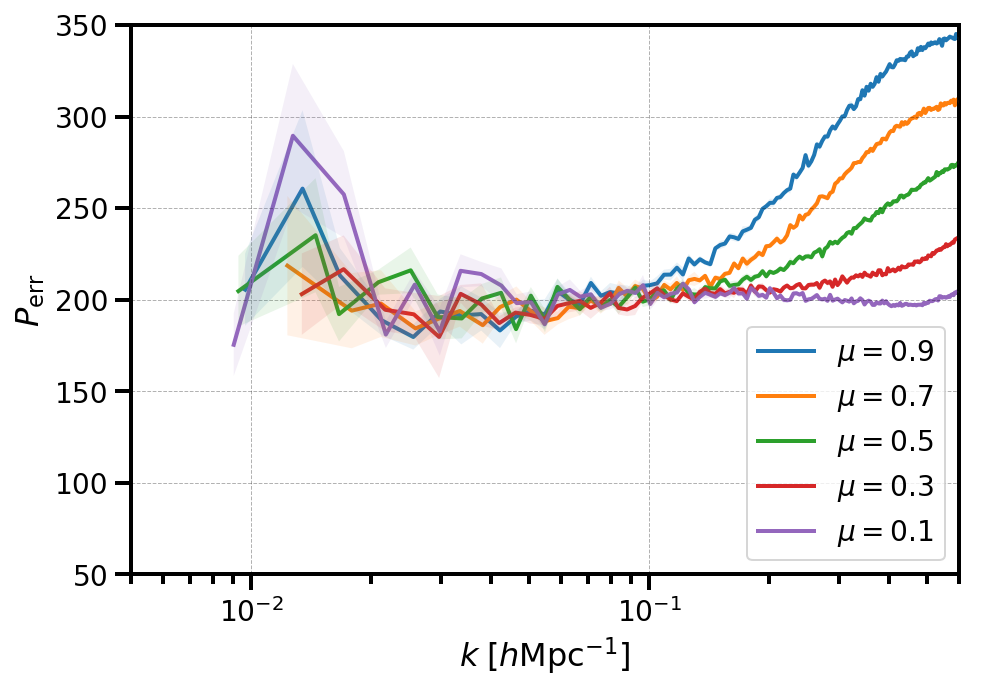

In [38]:
if True:
    # #################################################################################
    # PLOT Perr(k,mu)
    # #################################################################################

    USE_FITTED_TRF_FCN_FOR_PERR = True
       

    target, title = target_and_title

    # select halo mass bin (0 for galaxies)
    iM = 0
    log10M_min, log10M_max = halo_masses[iM]
    halo_mass_string = halo_mass_strings[iM]
   
    fig = plt.figure(figsize=(7,5))
    ax = plt.gca()

    vpkey = ((('sim_opts', 'halo_mass_string',), halo_mass_string),)

    print("stacked_vp_pickles keys:", stacked_vp_pickles.keys())
    stacked_pickles = stacked_vp_pickles[vpkey]
    base_pickle_opts = base_vp_pickles[vpkey]['opts']

    # get some basic info
    boxsize = int(base_pickle_opts['sim_opts'].boxsize)
    redshift = 1.0 / base_pickle_opts['sim_opts'].sim_scale_factor - 1.0
    kmin_plot = 1e-2
    kmax_plot = np.min(np.array([1.0, base_pickle_opts['grid_opts'].kmax]))

    base_pickle = base_vp_pickles[vpkey]
    print("tmp:", base_pickle['opts'].keys())
    trf_specs = base_pickle['opts']['trf_specs']
    trf_specs_save_bestfit_fields = [t.save_bestfit_field for t in trf_specs]
    trf_specs_targets = [t.target_field for t in trf_specs]

    # try to read number density:
    nbar_of_cat = get_nbar_of_cat(base_pickle)
    if nbar_of_cat.has_key(target):
        my_one_over_nbar = 1.0 / nbar_of_cat[target]
        denomi = my_one_over_nbar
    else:
        denomi = 1.0

    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    Nsims = stacked_pickles['Pkmeas'][tmp_key]['k'].shape[0]
    print("Nsims:", Nsims)
    assert Nsims == len(sim_seeds)

    N_ortho_iter = base_pickle_opts['trf_fcn_opts'].N_ortho_iter

    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    kvec = np.mean(stacked_pickles['Pkmeas'][tmp_key]['k'], axis=0)

    cic_window, eval_cic_window_at_kvec = get_cic_window(
        boxsize=base_pickle_opts['sim_opts'].boxsize, Ngrid=base_pickle_opts['grid_opts'].Ngrid,
        kvec=kvec)
    
    # get Pks, Nmu, Nk
    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    if USE_FITTED_TRF_FCN_FOR_PERR:
        Pks = fitted_stacked_pickles['Pkmeas']
    else:
        Pks = stacked_pickles['Pkmeas']
    Pk0 = Pks[Pks.keys()[0]]
    #Nmu = Pk0['Nmu'][0][0]
    #Nk = Pk0['Nk'][0][0]

    # plot difference of the next two trf specs
    tfspec = get_trf_spec_from_list(
        trf_specs=trf_specs, 
        save_bestfit_field=save_bestfit_field
    )
    
    residual_key_RSD = '[%s]_MINUS_[%s]' % (tfspec.save_bestfit_field, tfspec.target_field)      

    color_counter = -1
    for imu in range(Nmu)[::-1]:
        color_counter += 1

        # read kvec of current mu bin from realization 0
        kvec_this_mu = Pks[Pks.keys()[0]]['k2d'][0, :, imu]
        mu = Pks[Pks.keys()[0]]['mu2d'][0, -1, imu]

        # get Perr. uses fitted or not fitted trf fcns.
        ymat = Pks[(residual_key_RSD, residual_key_RSD)]['P2d'][:, :, imu]
        
        #if imu==Nmu-1:
        #    # lowest k bin in highest mu bin is always 0, exclude
        #    ymat[:,0] = np.nan
        if kvec_this_mu[0] < 0.02:
            #ymat[:,0] = np.nan
            pass

        # plot
        ww = np.where(kvec_this_mu<=1.0)[0]
        if True:
            # plot errors using fill_between
            yerr = np.std(ymat[:,ww], axis=0) / np.sqrt(
                float(Nsims - 1))
            mypatch = ax.fill_between(kvec_this_mu[ww],
                np.mean(ymat[:,ww], axis=0) - yerr,
                np.mean(ymat[:,ww], axis=0) + yerr,
                facecolor=colors[color_counter],
                zorder=4,
                lw=0, alpha=0.1)

        if True:
            # plot lines without error bars
            ax.semilogx(kvec_this_mu[ww], np.mean(ymat[:,ww], axis=0),
                zorder=1,
                lw=2, alpha=1, color=colors[color_counter], ls='-', 
                label=r'$\mu=%.2g$' % mu)
                
    # cosmetics
    ax.set_ylabel(r'$P_\mathregular{err}$')
    ax.set_xlim((0.005,0.6))
    ax.legend(loc='best', fontsize=14, ncol=1)
    ax.set_xlabel('$k\;[h\\mathrm{Mpc}^{-1}]$')
    #ax.set_ylim((450,2100))
    ax.set_ylim((50,350))
              
    plt.tight_layout()
    fname = '../pdf/Perr_RSD_v2_%s_fittedTk%d.pdf' % (target, int(USE_FITTED_TRF_FCN_FOR_PERR))
    plt.savefig(fname)
    print('Made %s' % fname)

## Fit Perr(k,mu) using polynomials in k and mu ##

In [27]:
Pks[(residual_key_RSD, residual_key_RSD)].keys()

['P2d', 'k', 'mu2d', 'mu', 'P', 'k2d']

In [28]:
print(Pks[(residual_key_RSD, residual_key_RSD)]['P2d'].shape)
print(Pks[(residual_key_RSD, residual_key_RSD)]['k'].shape)
print(Pks[(residual_key_RSD, residual_key_RSD)]['mu'].shape)
print(Pks[(residual_key_RSD, residual_key_RSD)]['P'].shape)

(6, 768, 5)
(6, 3840)
(6, 3840)
(6, 3840)


In [29]:
### GET CIC OR TSC WINDOW
window_str = base_pickle_opts['power_opts'].to_mesh_kwargs['window']
if window_str != 'cic':
    raise Exception('Perr code only uses cic, even if other window specified in options. Run with cic')
print(window_str)
window_at_kvec, eval_window_at_kvec = get_window_compensation(
    window=base_pickle_opts['power_opts'].to_mesh_kwargs['window'],
    boxsize=base_pickle_opts['sim_opts'].boxsize, Ngrid=base_pickle_opts['grid_opts'].Ngrid,
    kvec=kvec)
    

cic


In [30]:
# 1d vectors having (k_i, mu_i) of i-th k,mu bin
kvec = np.mean(Pks[(residual_key_RSD, residual_key_RSD)]['k'], axis=0)
muvec = np.mean(Pks[(residual_key_RSD, residual_key_RSD)]['mu'], axis=0)
Perrvec = np.mean(Pks[(residual_key_RSD, residual_key_RSD)]['P'], axis=0) / eval_window_at_kvec(kvec)
Pmodelvec = np.mean(Pks[(tfspec.save_bestfit_field, tfspec.save_bestfit_field)]['P'], axis=0) / eval_window_at_kvec(kvec)
#Nmodesvec = None

kmin_fit = 0.06  # was 0.04 or 0.1
kmax_fit = 0.3
ww = np.where( (kvec>kmin_fit) & (kvec<=kmax_fit) )[0]
ki = kvec[ww]
mui = muvec[ww]
Pmodeli = Pmodelvec[ww]
yi = Perrvec[ww]
Nmodesi = Nmodesvec[ww]

/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.


In [31]:
import statsmodels.api as sm

# specify regression features: k^n mu^m
def get_features_from_k_mu(ki, mui, Pmodeli):
    #X = np.column_stack(( np.ones(ki.shape[0]), ki, mui, ki*mui, (ki*mui)**2 ))
    #X = np.column_stack(( np.ones(ki.shape[0]), ki**2, (ki*mui)**2  ) )
    #X = np.column_stack(( np.ones(ki.shape[0]), (ki*mui)**2, (ki*mui)**4, mui**2, mui**4  ) )
    #X = np.column_stack(( np.ones(ki.shape[0]), (ki*mui)**2*Pmodeli, (ki*mui)**4*Pmodeli, (ki*mui)**6*Pmodeli   ) )
    #X = np.column_stack(( np.ones(ki.shape[0]), (ki*mui)**2, (ki*mui)**2*Pmodeli, (ki*mui)**4*Pmodeli  ) )
    #X = np.column_stack(( np.ones(ki.shape[0]), (ki*mui)**4*Pmodeli  ) )
    #X = np.column_stack(( np.ones(ki.shape[0]), ki**2, (ki*mui)**2, ki**2*mui**4, ki**4*mui**2  ) )  # R^2=0.91
    
    X = np.column_stack(( np.ones(ki.shape[0]),  (ki*mui)**2,   ) )
    #X = np.column_stack(( np.ones(ki.shape[0]), (ki*mui)**2, (ki*mui)**4  ) )
    #X = np.column_stack(( np.ones(ki.shape[0]), (ki*mui)**2, ki**4 * mui**2, (ki*mui)**4, ki**2  ) )
    #X = np.column_stack(( np.ones(ki.shape[0]), (ki*mui)**2, (ki*mui)**4, (ki*mui)**6  ) )  
    #X = np.column_stack(( np.ones(ki.shape[0]),  (ki*mui)**2, ki**4 * mui**2 ) )
    
    return X

# compute design matrix
X = get_features_from_k_mu(ki, mui, Pmodeli)
model = sm.OLS(yi, X)
#model = sm.WLS(yi, X, weights=1./Nmodesi)  # WLS takes sqrt of weights
fitresults = model.fit()
print(fitresults.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 1.504e+04
Date:                Tue, 24 Nov 2020   Prob (F-statistic):          2.41e-247
Time:                        21:49:20   Log-Likelihood:                -736.88
No. Observations:                 285   AIC:                             1478.
Df Residuals:                     283   BIC:                             1485.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        200.5807      0.244    823.233      0.0

In [32]:
fitresults.params[0]

200.58066600996074

In [33]:
6*1.5

9.0

In [34]:
if False:
    # try LASSO fitting
    results2 = model.fit_regularized(method='elastic_net', alpha=1.0, L1_wt=1.0)


stacked_vp_pickles keys: [((('sim_opts', 'halo_mass_string'), ''),)]
tmp: ['save_grids4plots', 'f_log_growth', 'out_rho_path', 'Pkmeas_helper_columns_calc_crosses', 'pickle_file_format', 'pickle_path', 'Pkmeas_helper_columns', 'power_opts', 'store_Pkmeas_in_trf_results', 'code_version_for_pickles', 'trf_specs', 'grids4plots_base_path', 'trf_fcn_opts', 'cats', 'grids4plots_R', 'ext_grids_to_load', 'grid_opts', 'sim_opts', 'keep_pickle', 'in_path', 'cache_base_path']
nbar_of_cat: OrderedDict()
Nsims: 6
cic
Made ../pdf/Perr_RSD_v2_fit_delta_gPTC_11.5_fittedTk1.pdf


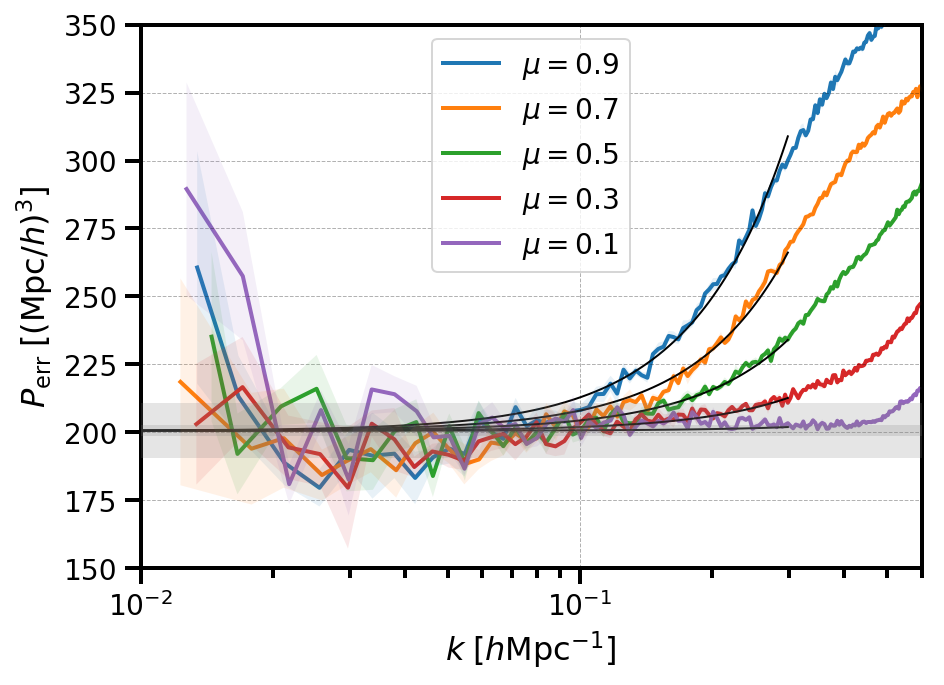

In [37]:
# plot fitted Perr(k,mu)
if True:

    kmin_plot, kmax_plot = 0.01, 0.6
    
    target, title = target_and_title

    # select halo mass bin (0 for galaxies)
    iM = 0
    log10M_min, log10M_max = halo_masses[iM]
    halo_mass_string = halo_mass_strings[iM]
   
    fig = plt.figure(figsize=(7,5))
    #fig = plt.figure(figsize=(14,10))
    ax = plt.gca()

    vpkey = ((('sim_opts', 'halo_mass_string',), halo_mass_string),)

    print("stacked_vp_pickles keys:", stacked_vp_pickles.keys())
    stacked_pickles = stacked_vp_pickles[vpkey]
    base_pickle_opts = base_vp_pickles[vpkey]['opts']

    # get some basic info
    boxsize = int(base_pickle_opts['sim_opts'].boxsize)
    redshift = 1.0 / base_pickle_opts['sim_opts'].sim_scale_factor - 1.0
    #kmin_plot = 1e-2
    #kmax_plot = np.min(np.array([1.0, base_pickle_opts['grid_opts'].kmax]))

    base_pickle = base_vp_pickles[vpkey]
    print("tmp:", base_pickle['opts'].keys())
    trf_specs = base_pickle['opts']['trf_specs']
    trf_specs_save_bestfit_fields = [t.save_bestfit_field for t in trf_specs]
    trf_specs_targets = [t.target_field for t in trf_specs]

    # try to read number density:
    nbar_of_cat = get_nbar_of_cat(base_pickle)
    print('nbar_of_cat:', nbar_of_cat)
    if nbar_of_cat.has_key(target):
        my_one_over_nbar = 1.0 / nbar_of_cat[target]
        denomi = my_one_over_nbar
    else:
        if target == 'delta_gPTC':
            denomi = 1400.
        elif target == 'delta_gPTC_GodPsiDot1':
            denomi = 2250.
        else:
            denomi = 1.0
            
    denomi = 1.0

    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    Nsims = stacked_pickles['Pkmeas'][tmp_key]['k'].shape[0]
    print("Nsims:", Nsims)
    assert Nsims == len(sim_seeds)

    N_ortho_iter = base_pickle_opts['trf_fcn_opts'].N_ortho_iter

    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    kvec = np.mean(stacked_pickles['Pkmeas'][tmp_key]['k'], axis=0)

    
    ### GET CIC OR TSC WINDOW
    print(base_pickle_opts['power_opts'].to_mesh_kwargs['window'])
    window_at_kvec, eval_window_at_kvec = get_window_compensation(
        window=base_pickle_opts['power_opts'].to_mesh_kwargs['window'],
        #window='tsc',
        boxsize=base_pickle_opts['sim_opts'].boxsize, Ngrid=base_pickle_opts['grid_opts'].Ngrid,
        kvec=kvec)
    

    # get Pks, Nmu, Nk
    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    #Pks = stacked_pickles['Pkmeas']
    #Pk0 = Pks[Pks.keys()[0]]
    ##Nmu = Pk0['Nmu'][0][0]
    #Nk = Pk0['Nk'][0][0]

    # plot difference of the next two trf specs
    tfspec = get_trf_spec_from_list(
        trf_specs=trf_specs, 
        save_bestfit_field=save_bestfit_field
    )
    
    residual_key_RSD = '[%s]_MINUS_[%s]' % (tfspec.save_bestfit_field, tfspec.target_field)      

    
    # plot 5%, 10% ranges
    if True:
        tmp_kvec = np.array([kmin_plot, kmax_plot])
        ycenter = fitresults.params[0]
        for percent in [1, 5]:
            mypatch = ax.fill_between(tmp_kvec,
                                      (100.-percent)/100.*ycenter,
                                      (100.+percent)/100.*ycenter,
                facecolor='grey',
                zorder=10,
                lw=0, alpha=0.2)
    
    color_counter = -1
    for imu in range(Nmu)[::-1]:
        color_counter += 1

        # read kvec of current mu bin from realization 0
        kvec_this_mu = Pks[Pks.keys()[0]]['k2d'][0, :, imu]
        mu = Pks[Pks.keys()[0]]['mu2d'][0, -1, imu]

        # get Perr
        ymat = Pks[(residual_key_RSD, residual_key_RSD)]['P2d'][:, :, imu]
        
        #if imu==Nmu-1:
        #    # lowest k bin in highest mu bin is always 0, exclude
        #    ymat[:,0] = np.nan
        if kvec_this_mu[0] < 0.01:
            ymat[:,0] = np.nan

        # plot
        ww = np.where((kvec_this_mu>=kmin_plot) & (kvec_this_mu<=kmax_plot))[0]
        if True:
            # plot errors using fill_between
            yerr = np.std(ymat[:,ww], axis=0) / np.sqrt(
                float(Nsims - 1))
            mypatch = ax.fill_between(kvec_this_mu[ww],
                (np.mean(ymat[:,ww], axis=0) - yerr)/denomi / eval_window_at_kvec(kvec_this_mu[ww]),
                (np.mean(ymat[:,ww], axis=0) + yerr)/denomi / eval_window_at_kvec(kvec_this_mu[ww]),
                facecolor=colors[color_counter],
                zorder=4,
                lw=0, alpha=0.1)

        if True:
            # plot lines without error bars
            ax.semilogx(kvec_this_mu[ww], 
                        np.mean(ymat[:,ww], axis=0)/denomi / eval_window_at_kvec(kvec_this_mu[ww]),
                zorder=1,
                lw=2, alpha=1, color=colors[color_counter], ls='-', 
                label=r'$\mu=%.2g$' % mu)

        if True:
            # plot fitted Perr(k,mu). this includes window already so don't divide out
            ww = np.where(kvec_this_mu<=kmax_fit)[0]
            this_ki = kvec_this_mu[ww]
            this_mui = np.ones(this_ki.shape)*mu
            ymat_model = Pks[(tfspec.save_bestfit_field, tfspec.save_bestfit_field)]['P2d'][:, :, imu]
            this_Pmodeli = np.mean(ymat_model[:,ww], axis=0)
            this_X = get_features_from_k_mu(this_ki, this_mui, this_Pmodeli)
            ax.semilogx(kvec_this_mu[ww], fitresults.predict(this_X)/denomi, 'k-', lw=1)
            
    if False:
        # plot CIC or tsc window
        kvec_tmp = np.logspace(np.log10(0.01), np.log10(0.6), 100)
        #ax.plot(kvec_this_mu[ww], 1400*eval_cic_window_at_kvec(kvec_this_mu[ww]), 'k--')
        ax.plot(kvec_tmp, 1394*eval_window_at_kvec(kvec_tmp), 'k--')
        #ax.plot(kvec, 1400*cic_window, 'k-.')
        # print(kvec_this_mu[ww].shape)
        #print(1400*eval_cic_window_at_kvec(kvec_this_mu[ww][:]).shape)
               
    # cosmetics
    if denomi != 1.:
        ax.set_ylabel(r'$P_\mathregular{err} / %g$' % denomi)
        ax.set_ylim((0.8,1.35))
    else:
        ax.set_ylabel(r'$P_\mathregular{err}\;[(\mathrm{Mpc}/h)^3]$')
        #ax.set_ylim((1300,1900))
        ax.set_ylim((150,350))
    
    ax.set_xlim((kmin_plot,kmax_plot))
    ax.legend(loc='best', fontsize=14, ncol=1)
    ax.set_xlabel('$k\;[h\\mathrm{Mpc}^{-1}]$')

    ax.set_xscale('log')
    #ax.set_yscale('log')
              
    #plt.tight_layout()
    fname = '../pdf/Perr_RSD_v2_fit_%s_fittedTk%d.pdf' % (target, int(USE_FITTED_TRF_FCN_FOR_PERR))
    plt.savefig(fname)
    print('Made %s' % fname)

## Plot Perr and Ptotal ##

stacked_vp_pickles keys: [((('sim_opts', 'halo_mass_string'), ''),)]
tmp: ['save_grids4plots', 'f_log_growth', 'out_rho_path', 'Pkmeas_helper_columns_calc_crosses', 'pickle_file_format', 'pickle_path', 'Pkmeas_helper_columns', 'power_opts', 'store_Pkmeas_in_trf_results', 'code_version_for_pickles', 'trf_specs', 'grids4plots_base_path', 'trf_fcn_opts', 'cats', 'grids4plots_R', 'ext_grids_to_load', 'grid_opts', 'sim_opts', 'keep_pickle', 'in_path', 'cache_base_path']
nbar_of_cat: OrderedDict()
Nsims: 6
cic
Made ../pdf/Ptot_Perr_RSD_v2_fit_delta_gPTC_11.5_fittedTk1.pdf


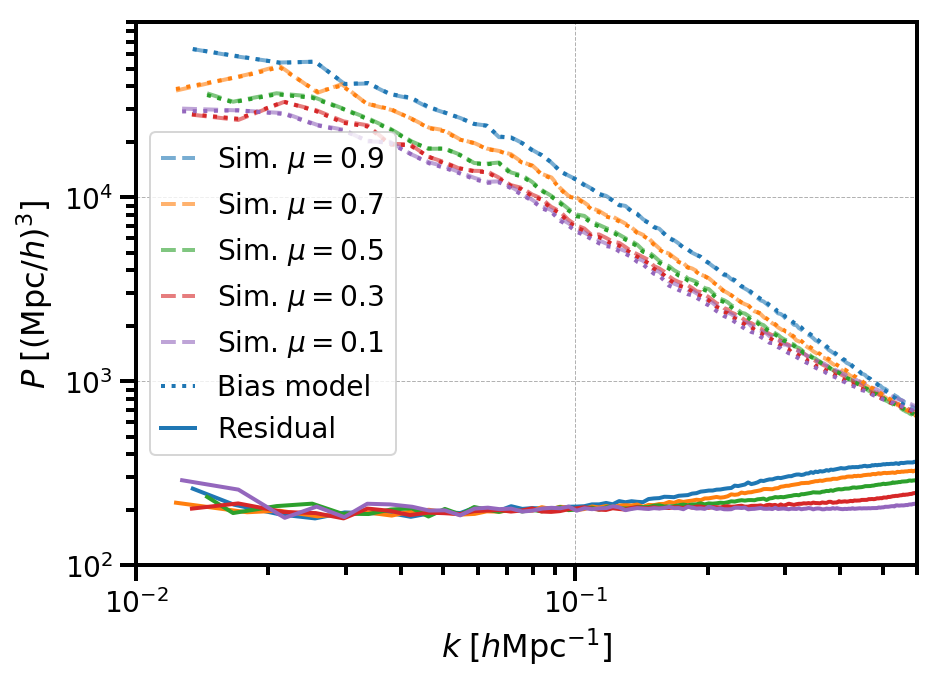

In [36]:
# plot fitted Perr(k,mu) and Ptotal
if True:

    kmin_plot, kmax_plot = 0.01, 0.6
    
    target, title = target_and_title

    # select halo mass bin (0 for galaxies)
    iM = 0
    log10M_min, log10M_max = halo_masses[iM]
    halo_mass_string = halo_mass_strings[iM]
   
    fig = plt.figure(figsize=(7,5))
    #fig = plt.figure(figsize=(14,10))
    ax = plt.gca()

    vpkey = ((('sim_opts', 'halo_mass_string',), halo_mass_string),)

    print("stacked_vp_pickles keys:", stacked_vp_pickles.keys())
    stacked_pickles = stacked_vp_pickles[vpkey]
    base_pickle_opts = base_vp_pickles[vpkey]['opts']

    # get some basic info
    boxsize = int(base_pickle_opts['sim_opts'].boxsize)
    redshift = 1.0 / base_pickle_opts['sim_opts'].sim_scale_factor - 1.0
    #kmin_plot = 1e-2
    #kmax_plot = np.min(np.array([1.0, base_pickle_opts['grid_opts'].kmax]))

    base_pickle = base_vp_pickles[vpkey]
    print("tmp:", base_pickle['opts'].keys())
    trf_specs = base_pickle['opts']['trf_specs']
    trf_specs_save_bestfit_fields = [t.save_bestfit_field for t in trf_specs]
    trf_specs_targets = [t.target_field for t in trf_specs]

    # try to read number density:
    nbar_of_cat = get_nbar_of_cat(base_pickle)
    print('nbar_of_cat:', nbar_of_cat)
    if nbar_of_cat.has_key(target):
        my_one_over_nbar = 1.0 / nbar_of_cat[target]
        denomi = my_one_over_nbar
    else:
        if target == 'delta_gPTC':
            denomi = 1400.
        elif target == 'delta_gPTC_GodPsiDot1':
            denomi = 2250.
        else:
            denomi = 1.0
            
    denomi = 1.0

    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    Nsims = stacked_pickles['Pkmeas'][tmp_key]['k'].shape[0]
    print("Nsims:", Nsims)
    assert Nsims == len(sim_seeds)

    N_ortho_iter = base_pickle_opts['trf_fcn_opts'].N_ortho_iter

    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    kvec = np.mean(stacked_pickles['Pkmeas'][tmp_key]['k'], axis=0)

    
    ### GET CIC OR TSC WINDOW
    print(base_pickle_opts['power_opts'].to_mesh_kwargs['window'])
    window_at_kvec, eval_window_at_kvec = get_window_compensation(
        window=base_pickle_opts['power_opts'].to_mesh_kwargs['window'],
        #window='tsc',
        boxsize=base_pickle_opts['sim_opts'].boxsize, Ngrid=base_pickle_opts['grid_opts'].Ngrid,
        kvec=kvec)
    

    # get Pks, Nmu, Nk
    tmp_key = stacked_pickles['Pkmeas'].keys()[0]
    #Pks = stacked_pickles['Pkmeas']
    #Pk0 = Pks[Pks.keys()[0]]
    ##Nmu = Pk0['Nmu'][0][0]
    #Nk = Pk0['Nk'][0][0]

    # plot difference of the next two trf specs
    tfspec = get_trf_spec_from_list(
        trf_specs=trf_specs, 
        save_bestfit_field=save_bestfit_field
    )
    
    residual_key = '[%s]_MINUS_[%s]' % (tfspec.save_bestfit_field, tfspec.target_field)
    curve_counter = -1
    for curve_key, curve_label, ls, alpha in [
        (tfspec.target_field, 'Sim.', '--', 0.6),
        (tfspec.save_bestfit_field, 'Bias model', ':', 1),
        (residual_key, 'Residual', '-', 1)
    ]:
        curve_counter += 1
    
        color_counter = -1
        for imu in range(Nmu)[::-1]:
            color_counter += 1

            # read kvec of current mu bin from realization 0
            kvec_this_mu = Pks[Pks.keys()[0]]['k2d'][0, :, imu]
            mu = Pks[Pks.keys()[0]]['mu2d'][0, -1, imu]

            # get Perr
            ymat = Pks[(curve_key, curve_key)]['P2d'][:, :, imu]

            #if imu==Nmu-1:
            #    # lowest k bin in highest mu bin is always 0, exclude
            #    ymat[:,0] = np.nan
            if kvec_this_mu[0] < 0.01:
                ymat[:,0] = np.nan

            # plot
            ww = np.where((kvec_this_mu>=kmin_plot) & (kvec_this_mu<=kmax_plot))[0]
            if False:
                # plot errors using fill_between
                yerr = np.std(ymat[:,ww], axis=0) / np.sqrt(
                    float(Nsims - 1))
                mypatch = ax.fill_between(kvec_this_mu[ww],
                    (np.mean(ymat[:,ww], axis=0) - yerr)/denomi / eval_window_at_kvec(kvec_this_mu[ww]),
                    (np.mean(ymat[:,ww], axis=0) + yerr)/denomi / eval_window_at_kvec(kvec_this_mu[ww]),
                    facecolor=colors[color_counter],
                    zorder=4,
                    lw=0, alpha=0.1)

            if True:
                # plot lines without error bars
                if curve_counter == 0:
                    label = r'%s $\mu=%.2g$' % (curve_label, mu)
                elif color_counter == 0:
                    label = curve_label
                else:
                    label = '_nolabel_'
                
                ax.semilogx(kvec_this_mu[ww], 
                            np.mean(ymat[:,ww], axis=0)/denomi / eval_window_at_kvec(kvec_this_mu[ww]),
                    #zorder=1,
                    lw=2, alpha=alpha, color=colors[color_counter], ls=ls, 
                    label=label)

            if False and curve_counter==2:
                # plot fitted Perr(k,mu). this includes window already so don't divide out
                ww = np.where(kvec_this_mu<=kmax_fit)[0]
                this_ki = kvec_this_mu[ww]
                this_mui = np.ones(this_ki.shape)*mu
                ymat_model = Pks[(tfspec.save_bestfit_field, tfspec.save_bestfit_field)]['P2d'][:, :, imu]
                this_Pmodeli = np.mean(ymat_model[:,ww], axis=0)
                this_X = get_features_from_k_mu(this_ki, this_mui, this_Pmodeli)
                ax.semilogx(kvec_this_mu[ww], fitresults.predict(this_X)/denomi, 'k-', lw=1)

        if False:
            # plot CIC or tsc window
            kvec_tmp = np.logspace(np.log10(0.01), np.log10(0.6), 100)
            #ax.plot(kvec_this_mu[ww], 1400*eval_cic_window_at_kvec(kvec_this_mu[ww]), 'k--')
            ax.plot(kvec_tmp, 1394*eval_window_at_kvec(kvec_tmp), 'k--')
            #ax.plot(kvec, 1400*cic_window, 'k-.')
            # print(kvec_this_mu[ww].shape)
            #print(1400*eval_cic_window_at_kvec(kvec_this_mu[ww][:]).shape)
               
    ax.set_ylabel(r'$P\;[(\mathrm{Mpc}/h)^3]$')
    ax.set_ylim((100,9e4))
    ax.set_yscale('log')
    #ax.set_ylim((150,350))
    
    ax.set_xlim((kmin_plot,kmax_plot))
    ax.legend(loc='best', fontsize=14, ncol=1, columnspacing=1.2, handlelength=1.2)
    ax.set_xlabel('$k\;[h\\mathrm{Mpc}^{-1}]$')

    ax.set_xscale('log')
    #ax.set_yscale('log')
              
    #plt.tight_layout()
    fname = '../pdf/Ptot_Perr_RSD_v2_fit_%s_fittedTk%d.pdf' % (target, int(USE_FITTED_TRF_FCN_FOR_PERR))
    plt.savefig(fname)
    print('Made %s' % fname)